In [1]:
from google.colab import files

uploaded = files.upload()

Saving techniques-classification.parquet to techniques-classification.parquet


In [7]:
!pip install torch transformers pandas numpy scikit-learn fastparquet > /dev/null 2>&1

# Base XLM-RoBERTa multi-label classification

## 1 Dependencies

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score,
    f1_score, accuracy_score
)

import ast

## 2 Seeds and Device

In [9]:
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 3 Dataset for manipulating techniques

In [10]:
class ManipulationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, techniques, tokenizer, max_len=512):
        self.texts = texts
        self.techniques = techniques
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Create label encoder
        self.unique_techniques = sorted(list(set(
            technique
            for techniques_list in self.techniques
            for technique in (ast.literal_eval(techniques_list) if isinstance(techniques_list, str)
                                                                else techniques_list.tolist()
                                                                if hasattr(techniques_list, 'tolist')
                                                                else techniques_list or [])
        )))
        self.technique_to_idx = {technique: idx for idx, technique in enumerate(self.unique_techniques)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])

        # Convert techniques to multi-hot encoding
        techniques = self.techniques[item]
        if isinstance(techniques, str):
            techniques = ast.literal_eval(techniques)

        label = torch.zeros(len(self.unique_techniques))
        if techniques is not None and len(techniques) > 0:
            for technique in techniques:
                label[self.technique_to_idx[technique]] = 1

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

## 4 Load Dataset

In [15]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

df = pd.read_parquet('/content/techniques-classification.parquet')

train_df, val_df = train_test_split(df, test_size=0.2)

train_dataset = ManipulationDataset(train_df['content'].values, train_df['techniques'].values, tokenizer)
val_dataset = ManipulationDataset(val_df['content'].values, val_df['techniques'].values, tokenizer)

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## 5 Model preparation

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)) > 0.5

    # Обчислення метрик
    precision = precision_score(labels, preds, average='micro')
    recall = recall_score(labels, preds, average='micro')
    f1 = f1_score(labels, preds, average='micro')
    accuracy = accuracy_score(labels, preds)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    'sentence-transformers/all-MiniLM-L6-v2',
    num_labels=len(train_dataset.unique_techniques),
    problem_type="multi_label_classification"
).to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='logs',
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    save_total_limit=2,
    logging_steps=100
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-76b195c9a9b3>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## 6 Train Model

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.421300,0.322481,0.512418,0.398779,0.448513,0.193464
2,0.322900,0.318738,0.552279,0.209563,0.303835,0.271895
3,0.323800,0.316912,0.538462,0.178026,0.267584,0.270588
4,0.310700,0.308027,0.600000,0.173957,0.269716,0.303268
5,0.305000,0.302538,0.628169,0.226857,0.333333,0.316340
6,0.298400,0.299952,0.609481,0.274669,0.378682,0.315033
7,0.295600,0.300194,0.607570,0.310275,0.410774,0.312418
8,0.290200,0.298963,0.612069,0.288911,0.392536,0.308497
9,0.280900,0.302314,0.608611,0.316378,0.416332,0.311111
10,0.277500,0.309619,0.564873,0.363174,0.442105,0.320261


TrainOutput(global_step=3840, training_loss=0.2769723437726498, metrics={'train_runtime': 1266.7555, 'train_samples_per_second': 48.265, 'train_steps_per_second': 3.031, 'total_flos': 2028336094863360.0, 'train_loss': 0.2769723437726498, 'epoch': 20.0})

In [ ]:
evaluation_feedback = trainer.evaluate()

## 7 Save Model

In [ ]:
trainer.save_model("models")
tokenizer.save_pretrained("models")


## 8 Metrics Visualisation

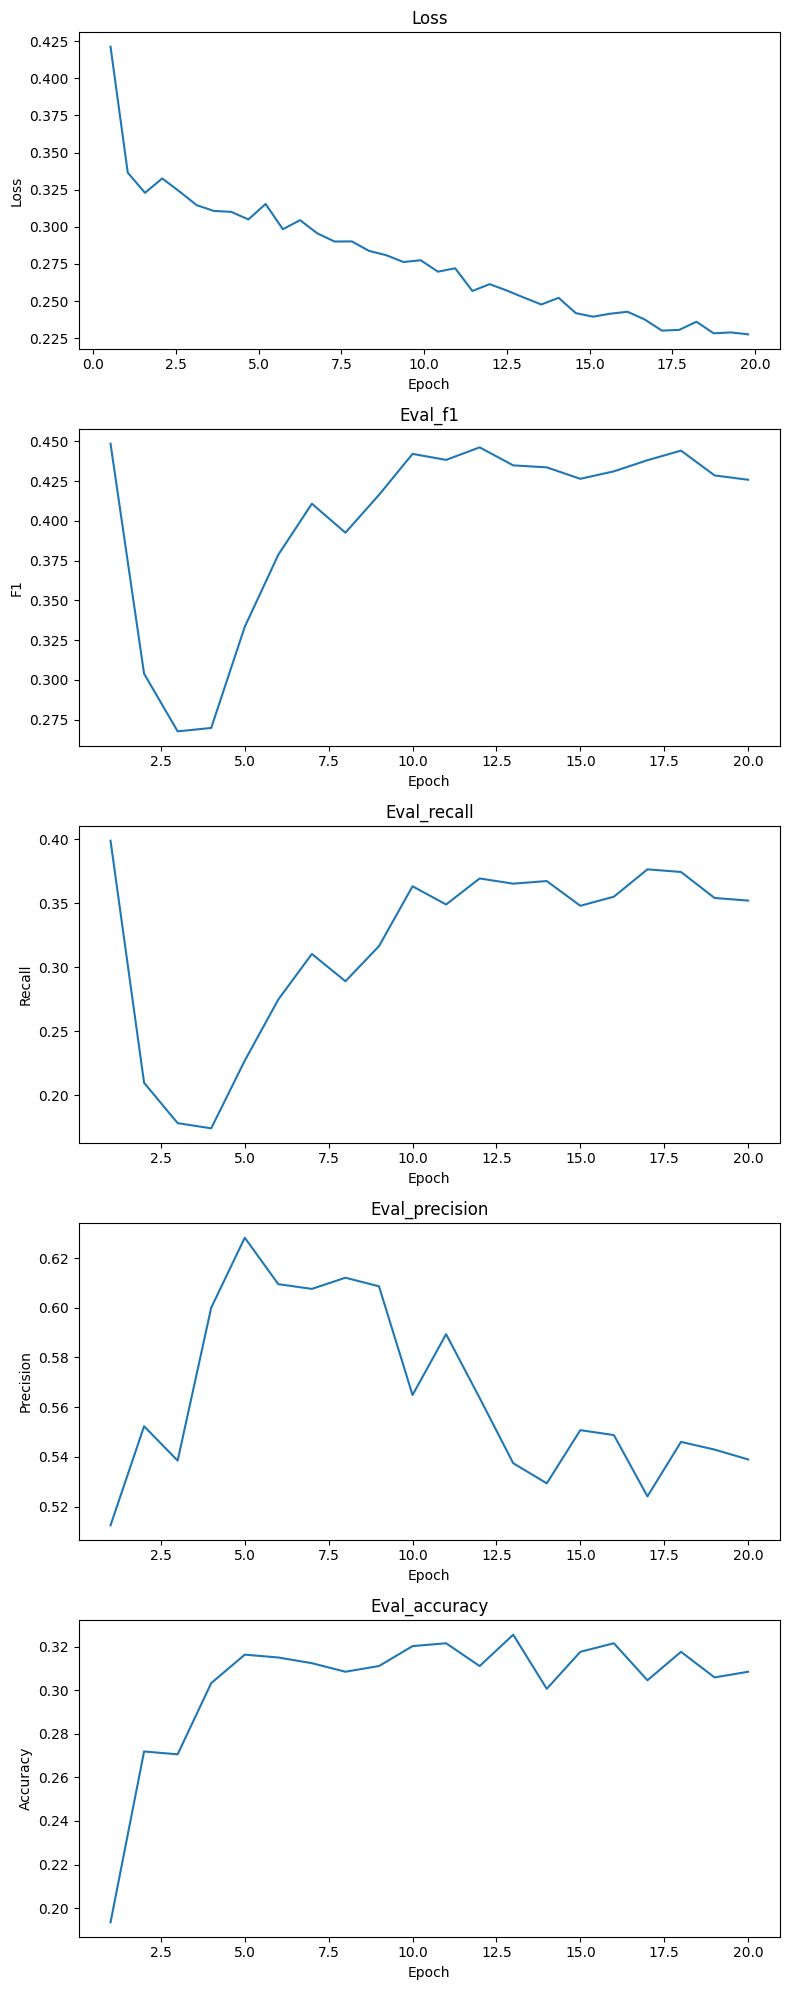

In [18]:
logs = trainer.state.log_history

# Metrics with corresponding epochs
metrics = ['loss', 'eval_f1', 'eval_recall', 'eval_precision', 'eval_accuracy']
data = {}
for metric in metrics:
    data[metric] = {'values': [], 'epochs': []}
    for log in logs:
        if metric in log:
            data[metric]['values'].append(log[metric])
            data[metric]['epochs'].append(log['epoch'])

# Plots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 4 * len(metrics)))

for i, metric in enumerate(metrics):
    axes[i].plot(data[metric]['epochs'], data[metric]['values'])
    axes[i].set_title(metric.capitalize())
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(metric.replace('eval_', '').capitalize())

plt.tight_layout()
plt.show()

## 9 Test

In [ ]:
def predict(text, model, tokenizer, unique_techniques):
    model.eval()
    model.to(device)
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(encoding['input_ids'], encoding['attention_mask']).logits
        predictions = torch.sigmoid(outputs) > 0.5

    predicted_techniques = [unique_techniques[i] for i, pred in enumerate(predictions[0]) if pred]
    return predicted_techniques

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("/content/models")
tokenizer = AutoTokenizer.from_pretrained("/content/models")

text_to_predict = "Уничтожение ВСУшников в Бахмуте артиллерией «Вагнер»"

unique_techniques = train_dataset.unique_techniques
predicted_techniques = predict(text_to_predict, model, tokenizer, unique_techniques)
predicted_techniques

['euphoria', 'loaded_language']

In [ ]:
!zip -r /content/checkpoints.zip /content/checkpoints
!zip -r /content/logs.zip /content/logs
!zip -r /content/models.zip /content/models

  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/checkpoint-1915/ (stored 0%)
  adding: content/checkpoints/checkpoint-1915/training_args.bin (deflated 52%)
  adding: content/checkpoints/checkpoint-1915/vocab.txt (deflated 45%)
  adding: content/checkpoints/checkpoint-1915/config.json (deflated 59%)
  adding: content/checkpoints/checkpoint-1915/tokenizer_config.json (deflated 75%)
  adding: content/checkpoints/checkpoint-1915/optimizer.pt (deflated 51%)
  adding: content/checkpoints/checkpoint-1915/trainer_state.json (deflated 72%)
  adding: content/checkpoints/checkpoint-1915/model.safetensors (deflated 7%)
  adding: content/checkpoints/checkpoint-1915/tokenizer.json (deflated 67%)
  adding: content/checkpoints/checkpoint-1915/scheduler.pt (deflated 56%)
  adding: content/checkpoints/checkpoint-1915/rng_state.pth (deflated 25%)
  adding: content/checkpoints/checkpoint-1915/special_tokens_map.json (deflated 42%)
  adding: content/checkpoints/checkpoint-4979/ (st